In [1]:
# Libraries for data loading, data viz and EDA
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for text preprocessing and analysis
import re,nltk,spacy,string
nlp=spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from tensorflow.keras import Sequential, Input, Model, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D, TextVectorization
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling, RandomWidth, RandomHeight, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# row/column display limit
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Objective

In IT support environments, handling large volumes of incoming tickets efficiently is crucial for reducing response time and improving customer satisfaction. This project aims to automate the classification of IT support tickets into predefined categories using Natural Language Processing (NLP) and Deep Learning. The aim is to make the model learn to understand textual descriptions and accurately predict the corresponding ticket category. This automation helps streamline ticket triaging, ensuring that issues are routed to the right teams faster and improving overall operational efficiency.

# Data Loading

In [2]:
df=pd.read_csv("IT_Support_Tickets.csv")
df.head()

,Issue_Description,Category
0,connection with icon icon dear please setup icon per icon engineers please let other details needed thanks lead,Hardware
1,work experience user work experience user hi work experience student coming next his name much appreciate him duration thank,Access
2,requesting for meeting requesting meeting hi please help follow equipments cable pc cord plug,Hardware
3,reset passwords for external accounts re expire days hi ask help update passwords colleagues thank pm expire days importance high hi received about expiration please kindly help prolongation best regards pm expire days importance high dear expire days order change please follow steps prerequisites disable device credentials close active connected by cable machine note also follow steps detailed press ctrl alt delete same pops change item enter format enter enter newly chosen then re enter again submit displaying has changed os machine browse enter format enter gear icon top tight browser window enter enter newly chosen then re enter again save connected note complete resources granted once connected by cable browse tick want change after logging enter format enter log enter enter newly chosen then re enter again change clients suppliers about expire please touch person then communicate back encounter issues hesitate by accessing yours,Access
4,NaN,NaN


In [3]:
df.dropna(how='all',inplace=True)
df.drop_duplicates(inplace=True)
df.shape

(31657, 2)

# Splitting Data

In [4]:
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [5]:
train_data2=train_data.copy(deep=True)
val_data2=val_data.copy(deep=True)
test_data2=test_data.copy(deep=True)

# Understanding Data

In [6]:
df=train_data.copy(deep=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22159 entries, 38879 to 37181
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Issue_Description  22159 non-null  object
 1   Category           22159 non-null  object
dtypes: object(2)
memory usage: 519.4+ KB


In [8]:
classes=df['Category'].unique().tolist()
classes

['Access', 'HR Support', 'Hardware']

In [9]:
df['Category'].value_counts()

,count
Category,
Hardware,9561
HR Support,7553
Access,5045


# Data Cleaning

In [10]:
# clean text function
def clean_texts(text):
    #Make the text lowercase
    text=text.lower()

    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)

    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)

    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text

In [11]:
df['Issue_Description']= df['Issue_Description'].apply(lambda x: clean_texts(x))

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22159 entries, 38879 to 37181
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Issue_Description  22159 non-null  object
 1   Category           22159 non-null  object
dtypes: object(2)
memory usage: 519.4+ KB


In [13]:
df["Issue_Description"] = df["Issue_Description"].str.replace('-PRON-', '')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22159 entries, 38879 to 37181
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Issue_Description  22159 non-null  object
 1   Category           22159 non-null  object
dtypes: object(2)
memory usage: 519.4+ KB


# Exploratory Data Analysis

Visualizing data as per description character length

Text(0, 0.5, 'No. of Issues')

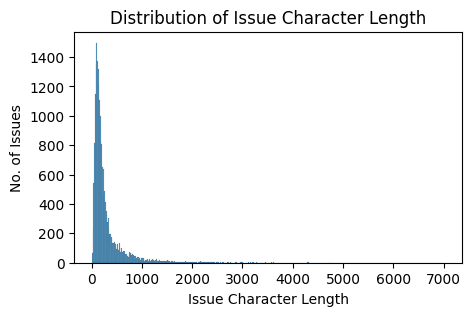

In [15]:
char_len=[len(x) for x in df['Issue_Description']]
plt.figure(figsize=[5,3])
sns.histplot(data = char_len)
plt.title('Distribution of Issue Character Length')
plt.xlabel('Issue Character Length')
plt.ylabel('No. of Issues')

Finding top 30 words by frequency

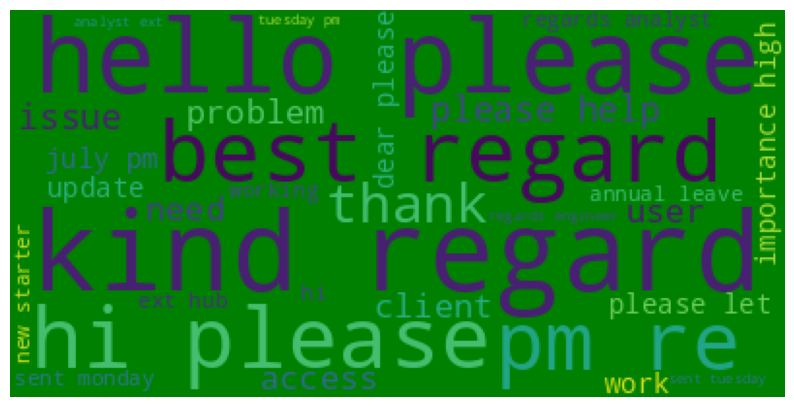

In [16]:
#Using a word cloud find the top 30 words by frequency among all the articles after processing the text
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='green',
                          stopwords=stop_words,
                          max_words=30,
                          random_state=42
                         ).generate(str(df['Issue_Description']))

fig = plt.figure(figsize=(10,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

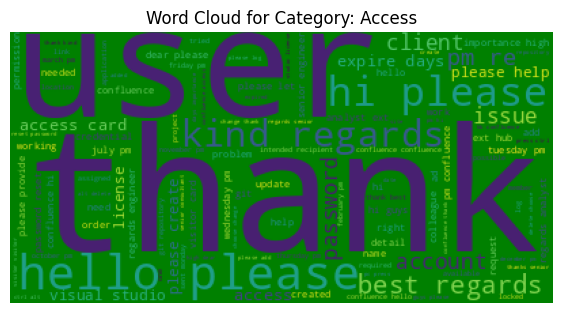

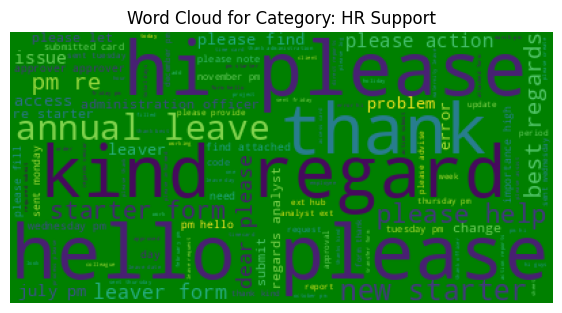

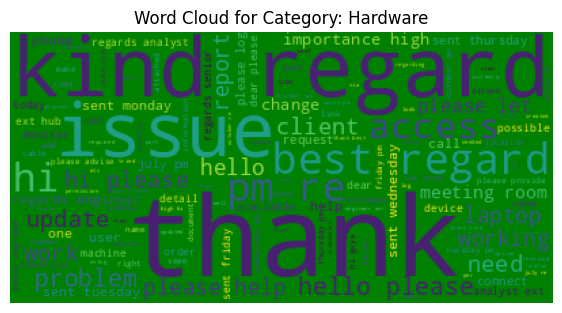

In [17]:
# word clouds for separate classes

categories = df['Category'].unique()

for category in categories:

    category_data = df[df['Category'] == category]

    # Generate the word cloud for the 'Issue_Description' column in the current category
    word_cloud = WordCloud(
        background_color='green',
        stopwords=stop_words,
        random_state=42
    ).generate(str(category_data['Issue_Description']))


    fig = plt.figure(figsize=(7,4))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title(f"Word Cloud for Category: {category}")
    plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22159 entries, 38879 to 37181
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Issue_Description  22159 non-null  object
 1   Category           22159 non-null  object
dtypes: object(2)
memory usage: 519.4+ KB


Visualizing top 10 Unigrams By Frequency

In [ ]:
def get_top_unigram(text, n=20):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

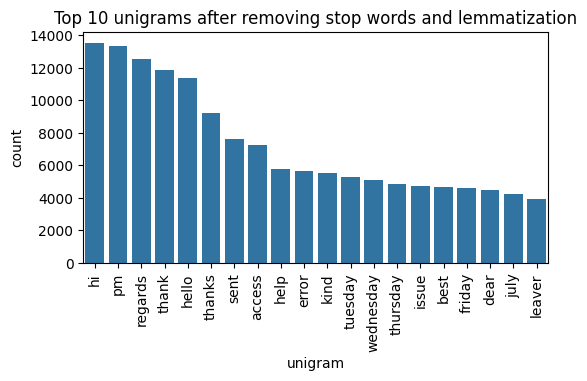

In [ ]:
top_common_words = get_top_unigram(df['Issue_Description'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
#df_unigram.head(10)
plt.figure(figsize=(6,3))
sns.barplot(x='unigram', y='count', data=df_unigram)
plt.xticks(rotation=90)
plt.title("Top 10 unigrams after removing stop words and lemmatization")
plt.show()

Visualizing Top 20 bigrams by frequency

In [ ]:
def get_top_bigram(text, n=20):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [ ]:
top_common_words = get_top_bigram(df['Issue_Description'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])

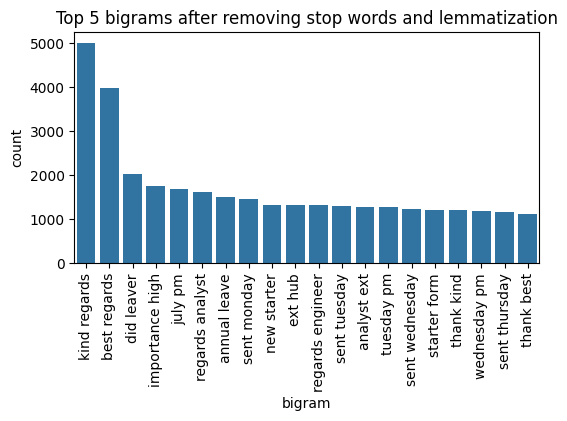

In [ ]:
plt.figure(figsize=(6,3))
sns.barplot(x='bigram', y='count', data=df_bigram)
plt.xticks(rotation=90)
plt.title("Top 5 bigrams after removing stop words and lemmatization")
plt.show()

# Encoding Target categories

In [ ]:
df.head()

,Category,Issue_Description
0,Hardware,connection icon icon dear setup icon icon engineer detail thank
1,Access,work experience user work work experience student name duration thank
2,Hardware,equipment cable pc cord plug
3,Access,password account day help password colleague pm day importance expiration prolongation regard pm day importance expire day order change step prerequisite device credential cable machine note step press ctrl pop item enter format machine browse enter format icon browser window enter note resource cable browse tick change format client supplier touch person encounter issue your
6,Hardware,server prod tunneling tunneling host host host card port name statistic packet loss si pm object host host host range host range administrator tunneling design lead object host host administrator sector tunneling tunneling user byte con care pot si pot ale care information dissemination recipient view transmission error author recipient distribute copy print


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31657 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Category           31657 non-null  object
 1   Issue_Description  31657 non-null  object
dtypes: object(2)
memory usage: 742.0+ KB


In [ ]:
df.replace({'Category':{"Hardware":0,
               "Access":1,
               "HR Support":2}},inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22159 entries, 38879 to 37181
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Issue_Description  22159 non-null  object
 1   Category           22159 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 519.4+ KB


# Data Preparation 1

## Lemmatization

In [ ]:
lp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Disable parser & NER speeds up processing

def process_texts(texts):
    processed_texts = []

    # Process texts in batch using nlp.pipe() for efficiency
    for doc in nlp.pipe(texts, batch_size=500, n_process=2):  # Increase batch size & enable multiprocessing
        # Extract noun lemmas
        nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN" and token.tag_ == "NN"]
        processed_texts.append(" ".join(nouns))

    return processed_texts



In [ ]:
df["Issue_Description"] = process_texts(df["Issue_Description"])

## TFIDF Vectorization

TfidfVectorizer uses Countvectorizer for BoW and TfidfTransformer.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000,stop_words='english')

In [ ]:
x_train_tfidf = tfidf_vectorizer.fit_transform(df['Issue_Description'])

In [ ]:
x_train=x_train_tfidf
y_train=df['Category']

# Test Data Preparation

In [ ]:
test_data['Issue_Description']= test_data['Issue_Description'].apply(lambda x: clean_texts(x))

In [ ]:
test_data["Issue_Description"] = process_texts(test_data["Issue_Description"])

In [ ]:
x_test_tfidf = tfidf_vectorizer.transform(test_data['Issue_Description'])

In [ ]:
test_data.replace({'Category':{"Hardware":0,
               "Access":1,
               "HR Support":2}},inplace=True)

In [ ]:
x_test=x_test_tfidf
y_test=test_data['Category']

# Model Building 1

## Custom Functions

In [ ]:

def model_eval(y_test, y_pred, model_name):

    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=['Hardware', 'Access', 'HR Support']))

    # plot confusion matrix of the classifier
    plt.figure(figsize=(5,3))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=['Hardware', 'Access', 'HR Support'],yticklabels=['Hardware', 'Access', 'HR Support'])
    plt.show()

    return

## Model 1 - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log=LogisticRegression()
model=log.fit(x_train,y_train)

In [ ]:
model.score(x_train,y_train)

0.8536486303533553

In [ ]:
model.score(x_test,y_test)

0.7852179406190777

In [ ]:
y_pred = log.predict(x_test)

CLASSIFICATION REPORT for LogisticRegression()

              precision    recall  f1-score   support

    Hardware       0.74      0.88      0.80      2025
      Access       0.89      0.67      0.76      1055
  HR Support       0.80      0.75      0.78      1669

    accuracy                           0.79      4749
   macro avg       0.81      0.76      0.78      4749
weighted avg       0.80      0.79      0.78      4749



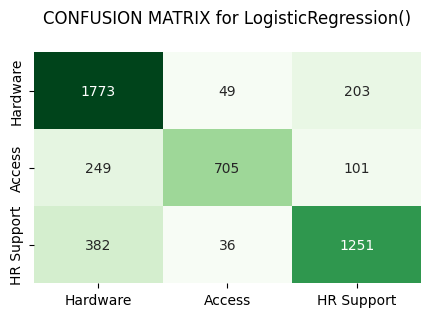

In [ ]:
model_eval(y_test, y_pred, log)

In [ ]:
f1_lr = f1_score(y_test, y_pred, average="weighted")
f1_lr

0.783907237935272

## Model 2 - RandomForest

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Define hyperparameters for tuning
param_rf = {
    'max_depth': [5,7],
    'min_samples_split': [5, 10]
}

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with StratifiedKFold
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=param_rf,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=cv,
                       verbose=1)

# Fit the model
grid_rf.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_rf.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'max_depth': 7, 'min_samples_split': 10}


In [ ]:
best_rf = grid_rf.best_estimator_

In [ ]:
y_pred_train = best_rf.predict(x_train)
y_pred_test = best_rf.predict(x_test)

In [ ]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.51      0.99      0.68      9561
           1       1.00      0.04      0.08      5045
           2       0.95      0.43      0.59      7553

    accuracy                           0.58     22159
   macro avg       0.82      0.49      0.45     22159
weighted avg       0.77      0.58      0.51     22159

              precision    recall  f1-score   support

           0       0.48      0.99      0.65      2025
           1       1.00      0.01      0.02      1055
           2       0.94      0.33      0.49      1669

    accuracy                           0.54      4749
   macro avg       0.81      0.44      0.39      4749
weighted avg       0.76      0.54      0.45      4749



CLASSIFICATION REPORT for RandomForestClassifier(max_depth=7, min_samples_split=10, random_state=42)

              precision    recall  f1-score   support

    Hardware       0.48      0.99      0.65      2025
      Access       1.00      0.01      0.02      1055
  HR Support       0.94      0.33      0.49      1669

    accuracy                           0.54      4749
   macro avg       0.81      0.44      0.39      4749
weighted avg       0.76      0.54      0.45      4749



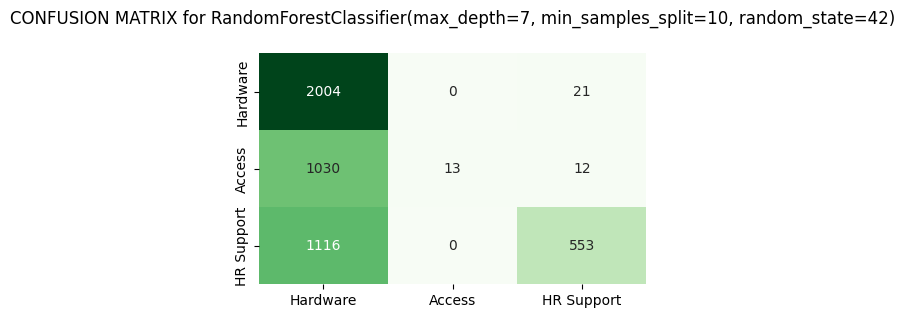

In [ ]:
model_eval(y_test, y_pred_test, best_rf)

In [ ]:
f1 = f1_score(y_test, y_pred_test, average="weighted")
f1

0.4545451743016351

With Logistic Regression:
- Train accuracy: 0.8536
- Test accuracy: 0.7852
- Test f1 score: 0.7839

With RandomForest:
- Train accuracy: 0.58
- Test accuracy: 0.54
- Test f1 score: 0.4545

# Data Preperation 2 - Using Pretrained Embeddings

In [ ]:
df=train_data2.copy(deep=True)

In [ ]:
descriptions = df['Issue_Description'].astype(str).values


## Tokenizing

In [ ]:
# Tokenization
max_words = 20000  # Vocabulary size
max_len = 500  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

tokenizer.fit_on_texts(descriptions)

In [ ]:
def preprocess_text(data, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(data["Issue_Description"].astype(str))
    return pad_sequences(sequences, maxlen=max_len, padding='post')

In [ ]:
x_train = preprocess_text(df, tokenizer)
x_val = preprocess_text(val_data2, tokenizer)

## Loading Glove

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-02-25 17:42:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-25 17:42:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-25 17:42:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_path = "glove.6B.100d.txt"

embedding_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

len(embedding_index)

400000

## Creating Embedding Matrix

In [ ]:
# Create embedding matrix using only words from training vocabulary
word_index = tokenizer.word_index
glove_embedding_dim = 100
embedding_matrix = np.zeros((max_words, glove_embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Encoding target categories

In [ ]:
df.replace({'Category':{"Hardware":0,
               "Access":1,
               "HR Support":2}},inplace=True)
y_train = df['Category'].values

val_data2.replace({'Category':{"Hardware":0,
               "Access":1,
               "HR Support":2}},inplace=True)
y_val = val_data2['Category'].values

In [ ]:
# one hot encoding

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# Test Data Preparation

In [ ]:
x_test = preprocess_text(test_data2, tokenizer)

In [ ]:
test_data2.replace({'Category':{"Hardware":0,
               "Access":1,
               "HR Support":2}},inplace=True)
y_test = test_data2['Category'].values

In [ ]:
y_test = to_categorical(y_test)

# Model Building 2

## Creating Embedding Layer

In [ ]:
embedding_layer = Embedding(
    max_words,
    glove_embedding_dim,
    weights=[embedding_matrix],
    input_length=100,
    # freeze the layer via trainable=False: so as to not to disrupt the pretrained representations during training
    trainable=False,
    mask_zero=True
)

## Model 1 - GRU

# New Section

In [ ]:
GRU_model = Sequential([
    embedding_layer,
    GRU(units = 64, input_shape = (None, 500)),
    Dense(units = 3, activation = 'softmax')  #multi-class classification
])
# Compile the model
GRU_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',  #multi-class classification
              metrics = ['accuracy'])

GRU_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
GRU_history = GRU_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 72s 96ms/step - accuracy: 0.6420 - loss: 0.7771 - val_accuracy: 0.8610 - val_loss: 0.3814
Epoch 2/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - accuracy: 0.8673 - loss: 0.3489 - val_accuracy: 0.8762 - val_loss: 0.3229
Epoch 3/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - accuracy: 0.8938 - loss: 0.2848 - val_accuracy: 0.8920 - val_loss: 0.2889
Epoch 4/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 90s 101ms/step - accuracy: 0.9062 - loss: 0.2451 - val_accuracy: 0.8941 - val_loss: 0.2880
Epoch 5/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 70s 84ms/step - accuracy: 0.9137 - loss: 0.2228 - val_accuracy: 0.9023 - val_loss: 0.2751
Epoch 6/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.9279 - loss: 0.1919 - val_accuracy: 0.9038 - val_loss: 0.2663
Epoch 7/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.9343 - loss: 0.1812 - val_accuracy: 0.8968 - val_loss: 0.2769
Epoch 8/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9426 - loss: 0.1582 

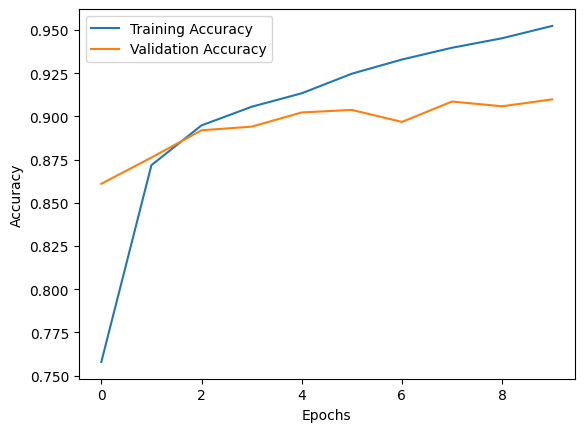

In [ ]:
plt.plot(GRU_history.history['accuracy'], label='Training Accuracy')
plt.plot(GRU_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = GRU_model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9060 - loss: 0.2727
Test Accuracy: 0.9039797782897949


In [ ]:
y_pred = GRU_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred_classes, average='weighted')


print(f'Test F1 Score: {f1:.4f}')

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Test F1 Score: 0.9040


## Model 2 - LSTM

In [ ]:
LSTM_model = Sequential([
    embedding_layer,
    LSTM(units = 64, input_shape = (None, 500)),
    Dense(units = 3, activation = 'softmax')
])
# Compile the model
LSTM_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

LSTM_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
# Train model
LSTM_history=LSTM_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 75s 108ms/step - accuracy: 0.9561 - loss: 0.1191 - val_accuracy: 0.8983 - val_loss: 0.3305
Epoch 2/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 67s 87ms/step - accuracy: 0.9623 - loss: 0.1085 - val_accuracy: 0.8991 - val_loss: 0.3356
Epoch 3/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.9642 - loss: 0.0951 - val_accuracy: 0.8966 - val_loss: 0.3464
Epoch 4/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.9690 - loss: 0.0825 - val_accuracy: 0.8977 - val_loss: 0.3602
Epoch 5/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.9752 - loss: 0.0723 - val_accuracy: 0.8964 - val_loss: 0.3905
Epoch 6/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9768 - loss: 0.0657 - val_accuracy: 0.8989 - val_loss: 0.3930
Epoch 7/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 85s 86ms/step - accuracy: 0.9820 - loss: 0.0541 - val_accuracy: 0.8981 - val_loss: 0.3946
Epoch 8/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.9797 - loss: 0.0570 -

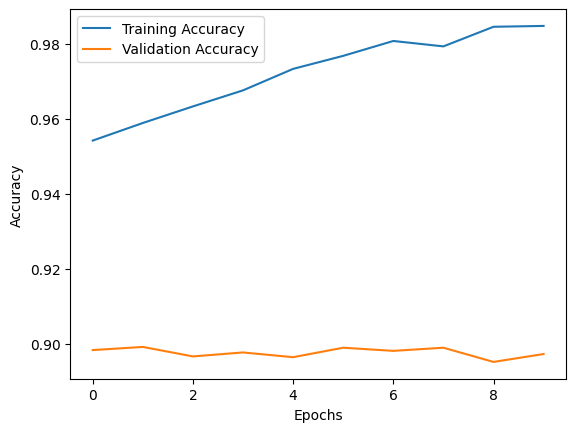

In [ ]:
plt.plot(LSTM_history.history['accuracy'], label='Training Accuracy')
plt.plot(LSTM_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = LSTM_model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8945 - loss: 0.4462
Test Accuracy: 0.8955569863319397


In [ ]:
y_pred = LSTM_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred_classes, average='weighted')


print(f'Test F1 Score: {f1:.4f}')

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Test F1 Score: 0.8956


Overfit noted. Using dropout to reduce overfit.

## Model 3 - LSTM With Dropout

In [ ]:
# Improve model with Dropout
LSTM_model_with_dropout = Sequential([
    embedding_layer,
    Dropout(0.25),
    LSTM(units = 64, dropout = 0.25, input_shape = (None, 500)),
    Dropout(0.25),
    Dense(units = 3 , activation = 'softmax')
])

# Compile the model
LSTM_model_with_dropout.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Print the model summary
LSTM_model_with_dropout.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
LSTM2_history=LSTM_model_with_dropout.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, batch_size=32)

Epoch 1/40
693/693 ━━━━━━━━━━━━━━━━━━━━ 65s 93ms/step - accuracy: 0.8904 - loss: 0.2943 - val_accuracy: 0.8968 - val_loss: 0.2819
Epoch 2/40
693/693 ━━━━━━━━━━━━━━━━━━━━ 80s 90ms/step - accuracy: 0.8947 - loss: 0.2791 - val_accuracy: 0.9099 - val_loss: 0.2542
Epoch 3/40
693/693 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.8957 - loss: 0.2805 - val_accuracy: 0.9023 - val_loss: 0.2625
Epoch 4/40
693/693 ━━━━━━━━━━━━━━━━━━━━ 60s 87ms/step - accuracy: 0.8994 - loss: 0.2645 - val_accuracy: 0.9080 - val_loss: 0.2479
Epoch 5/40
693/693 ━━━━━━━━━━━━━━━━━━━━ 83s 89ms/step - accuracy: 0.8988 - loss: 0.2630 - val_accuracy: 0.9071 - val_loss: 0.2544
Epoch 6/40
693/693 ━━━━━━━━━━━━━━━━━━━━ 63s 90ms/step - accuracy: 0.9009 - loss: 0.2534 - val_accuracy: 0.9076 - val_loss: 0.2634
Epoch 7/40
693/693 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - accuracy: 0.9009 - loss: 0.2503 - val_accuracy: 0.9103 - val_loss: 0.2504
Epoch 8/40
693/693 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.9069 - loss: 0.2469 - 

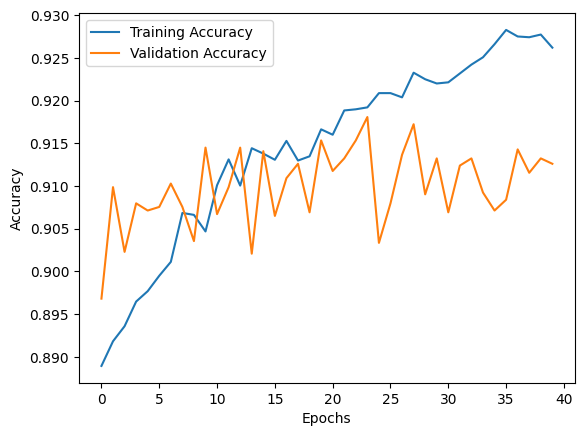

In [ ]:
plt.plot(LSTM2_history.history['accuracy'], label='Training Accuracy')
plt.plot(LSTM2_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = LSTM_model_with_dropout.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9150 - loss: 0.2322
Test Accuracy: 0.9130343198776245


In [ ]:
y_pred = LSTM_model_with_dropout.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred_classes, average='weighted')


print(f'Test F1 Score: {f1:.4f}')

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Test F1 Score: 0.9131


The LSTM model with dropout overcame overfit and provided highest test accuracy and f1 score.

# Conclusion

Selected Model:

LSTM Model with Dropout:

LSTM_model_with_dropout = Sequential([
    embedding_layer,
    Dropout(0.25),
    LSTM(units = 64, dropout = 0.25, input_shape = (None, 500)),
    Dropout(0.25),
    Dense(units = 3 , activation = 'softmax')
])


- Train accuracy: 0.9270

- Test accuracy: 0.9130

- Test F1 score: 0.9131